In [1]:
import csv
from overlap import *
import numpy as np

import networkx as nx
import numpy as np
from HCS import HCS

import matplotlib.pyplot as plt

# Overlap algorithm

### Create similarity matrix from the CSV regions file

Load meta data 

In [17]:
#get metadata and sizes of the cell types
with open('meta_data.csv','r') as file:
    reader = csv.reader(file)
    
    for index,line in enumerate(reader):
        if index == 0:
            cell_types = line #each index is cell type
        elif index == 1:
            sizes = [int(p) for p in line] #each index is amount of active regions in cell type

Load active regions

In [7]:
data = [] #every 23 rows/lists belong to one cell type (same order as cell_types list), every list of 23 is a chromosome (1 t/m 22 + X)
with open('region_data.csv','r') as file:
    reader = csv.reader(file)
    
    for row in reader:
        data.append([int(p) for p in row]) 

Run overlap algorithm on the active regions to get the (non-normalized) overlap matrix

In [ ]:
# 23 iterations, one to compute overlap of each chromosome
# on 1st iteration we take lists 0,23,46,...
# on 2nd iteration we take lists 1,24,47,... etc

cell_type_indices = [i for i in range(0,len(data),23)] 

k = len(data)//23
total_overlap_matrix = np.zeros((k,k))

for i in range(23):
    chrom_indices = [j+i for j in cell_type_indices]
    chrom_data = [data[chrom_index] for chrom_index in chrom_indices]

    overlap_matrix = sweepline_overlap(chrom_data) #overlap matrix of one chromosome -> add to total overlap
    total_overlap_matrix += overlap_matrix

    print('Overlap of chromosome {} out of {} finished'.format(i+1,23))

In [11]:
np.save('overlap_matrix.npy',total_overlap_matrix)

Compute (normalized) similarity matrix 

In [36]:
total_overlap_matrix = np.load('overlap_matrix.npy')

In [ ]:
k = total_overlap_matrix.shape[0]
similarity_matrix = np.empty((k,k))

# diagonals are 0's
for i in range(k):
    similarity_matrix[i][i] = 1

# loop through bottom triangle of matrix, due to symmetry top right triangle can be copy 
for i in range(1,k):
    for j in range(i):
        denom = max(sizes[i],sizes[j])
        #maximum value of 1
        similarity_matrix[i][j] = min(1,total_overlap_matrix[i][j] /denom)
        similarity_matrix[j][i] = min(1,total_overlap_matrix[j][i] /denom)

In [21]:
np.save('similarity_matrix.npy',similarity_matrix)

Load similarity matrix if it's already created

In [21]:
similarity_matrix = np.load('similarity_matrix.npy')

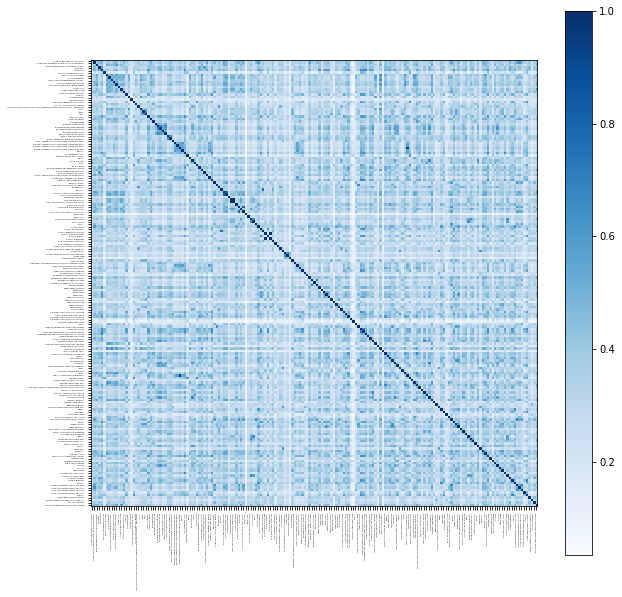

In [98]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([i for i in range(k)])
ax.set_yticks([i for i in range(k)])
# ax.tick_params(axis='both', which='minor', labelsize=0.1)
plt.xticks(fontsize=2, rotation=90)
plt.yticks(fontsize=2)
ax.set_xticklabels(cell_types)
ax.set_yticklabels(cell_types)
im = plt.imshow(similarity_matrix, cmap='Blues', interpolation='nearest')
fig.colorbar(im)
plt.show()

# HCS clustering

In [ ]:
HCS_model = HCS(similarity_matrix)
sim_threshold = HCS_model.getSimilarityThreshold(fraction_threshold = 0.3) 
HCS_model.buildGraph(sim_threshold = sim_threshold) 

clusters = HCS_model.cluster(remove_low_degree_nodes=(False, 1))

In [ ]:
HCS_model.drawGraphs()

In [67]:
# get cells of a specific cluster
[[cell_types[i] for i in list(cluster.nodes)] for cluster in clusters][2]

['Fetal Stomach',
 'V1058; Colorectal cancer cell line',
 'V411; Colorectal cancer cell line',
 'V703; Colorectal cancer cell line',
 'CJM Melanoma Cell',
 'Epithelium; Fetal Large Intestine',
 'Epithelium; Fetal Small Intestine',
 'primary colorectal cancer tumor']